# Introduction to design matrices

[Tom Wallis](http://www.tomwallis.info) and [Philipp Berens](http://philippberens.wordpress.com/)


The University of Tübingen


In [2]:
# import necessary modules:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import patsy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sm_stats
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_style("white")

# Introduction

The Generalised Linear Model (GLM) is a flexible way to combine different *predictor variables* to predict the value of a *response variable*. Many common statistical procedures are types of GLMs - t-tests, multiple regression, ANOVA, ANCOVA, etc. Furthermore, many more complicated statistical procedures are extensions of GLMs. An understanding of how GLMs work is therefore very useful.

In the next few lectures we want to provide an overview of how GLMs work, with some simple examples. In particular, we want you to understand
  + how to build design matrices
  + the meaning of coefficients in a design matrix
  + what a link function is

# General form of the model

The general form of a GLM can be written as 

$y = f(\mathbf{X}\beta) + \epsilon$


- $\mathbf{X}$: the design matrix, where columns are predictors, rows are observations

- $y$ is the response variable we're trying to predict (a column vector)

- $\beta$ is a vector of weights, with the same length as the number of columns in the design matrix

- $\mathbf{X} \beta$ is called the *linear predictor*

- $f()$ is some transformation of the weighted design matrix (the inverse of link function). Examples include logistic, logarithmic, Poisson...

- $\epsilon$ is random noise of some type.

<img src="data/pics_for_lectures.001.png">

(note that in the picture above, the vector of weights $\beta$ should really appear tall rather than wide because it's a column vector; I've drawn it this way to emphasise that it has the same *length* as the number of *columns* in $\mathbf{X}$)

Another way to write $\mathbf{X}\beta$ is in vector notation:

$x_1\beta_1 + x_2\beta_2 + ... + x_n\beta_n$

- $x_n$ are column vectors
- $\beta_n$ is a scalar

So the term $\mathbf{X}\beta$ is a linear weighted sum of predictors (i.e., it's a *linear* model). Let's look at a concrete example of this in action.

# Example: simple linear regression

Let's go back to our "Sleep in Mammals" dataset from the dataframe / plotting lecture.

First, we import the data, drop missing cases, and create our log bodyweight variable.

In [3]:
# import the dataset csv file into a Pandas dataframe object:
sleep = pd.read_csv('./data/sleep.txt', sep='\t') 
sleep = sleep.dropna(axis=0)  # drop on axis 0 (i.e. rows)
sleep['log_BodyWt'] = np.log(sleep['BodyWt'])
sleep['log_BrainWt'] = np.log(sleep['BrainWt'])
sleep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 1 to 60
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Species      42 non-null     object 
 1   BodyWt       42 non-null     float64
 2   BrainWt      42 non-null     float64
 3   NonDreaming  42 non-null     float64
 4   Dreaming     42 non-null     float64
 5   TotalSleep   42 non-null     float64
 6   LifeSpan     42 non-null     float64
 7   Gestation    42 non-null     float64
 8   Predation    42 non-null     int64  
 9   Exposure     42 non-null     int64  
 10  Danger       42 non-null     int64  
 11  log_BodyWt   42 non-null     float64
 12  log_BrainWt  42 non-null     float64
dtypes: float64(9), int64(3), object(1)
memory usage: 4.6+ KB


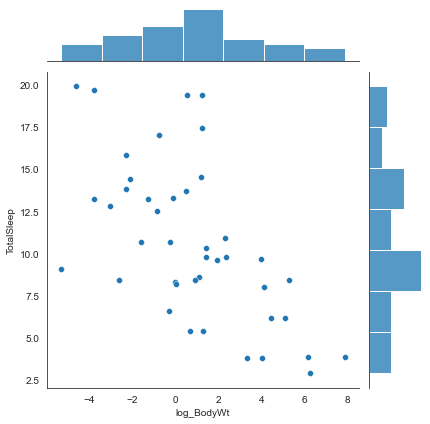

In [4]:
g = sns.jointplot("log_BodyWt", "TotalSleep", sleep)

We can see that the log of bodyweight seems to be related to TotalSleep approximately linearly (although the variance is higher for low bodyweights).

**How many hours does a species of animal sleep on average, given its bodyweight?**

To answer this question we can use a linear regression. We have a single *predictor* variable (the log of bodyweight) to predict our *response variable* of interest (Total hours of sleep). 

As you know from high school maths, the equation for a line can be written as $y = mx + c$. That is, we would like to estimate two parameters: the a slope as a function of $x$, and an intercept (the value of $y$ when $x$ is zero). 

# Design matrices

The design matrix $\mathbf X$ has *predictor variables* in its columns. Remember that we will estimate one parameter (the $\beta$ weight) for *each column of the design matrix*. 

The design matrix is not necessarily just a copy of the columns in our data frame. Sometimes variables need to be transformed to have a certain meaning within the model. We can use a module called *Patsy* to create design matrices automatically from our specification of the model.

## Patsy and *S*-style formulae

The Patsy package allows us to specify the model we want to fit in a high-level formula language, based on the one used in the ancient *S* statistical language (and now more recently in *R*). 

Patsy allows us to specify

- our model
- the data frame containing the variables we want to use
    
and returns the design matrix $\mathbf X$ (and optionally also $y$).

Formulae have the general form `y ~ x`.

- everthing to the left of the `~` character are the things we want to predict (response variable)
- everything to the right are the predictors
- we can use the names of variables in our data frame to make the code more readable

To make this more concrete, let's look at an example for our linear regression above.

In [5]:
sleep.head()

Species    BodyWt  BrainWt  NonDreaming  Dreaming  \
1  Africangiantpouchedrat     1.000      6.6          6.3       2.0   
4           Asianelephant  2547.000   4603.0          2.1       1.8   
5                  Baboon    10.550    179.5          9.1       0.7   
6             Bigbrownbat     0.023      0.3         15.8       3.9   
7          Braziliantapir   160.000    169.0          5.2       1.0   

   TotalSleep  LifeSpan  Gestation  Predation  Exposure  Danger  log_BodyWt  \
1         8.3       4.5       42.0          3         1       3    0.000000   
4         3.9      69.0      624.0          3         5       4    7.842671   
5         9.8      27.0      180.0          4         4       4    2.356126   
6        19.7      19.0       35.0          1         1       1   -3.772261   
7         6.2      30.4      392.0          4         5       4    5.075174   

   log_BrainWt  
1     1.887070  
4     8.434464  
5     5.190175  
6    -1.203973  
7     5.129899

In [7]:
# this command returns both X and y (hence "dmatrices" plural). See "dmatrix" if you just want X.
y, X = patsy.dmatrices('TotalSleep ~ log_BodyWt', sleep)

X

DesignMatrix with shape (42, 2)
  Intercept  log_BodyWt
          1     0.00000
          1     7.84267
          1     2.35613
          1    -3.77226
          1     5.07517
          1     1.19392
          1     3.95432
          1    -0.85567
          1     6.14204
          1    -2.59027
          1     1.09861
          1    -0.24207
          1    -1.60944
          1     3.31999
          1    -2.12026
          1     4.44265
          1    -2.29263
          1     0.03922
          1     6.25575
          1    -5.29832
          1    -4.60517
          1     4.12713
          1    -3.77226
          1    -3.03655
          1     0.53063
          1     1.25276
          1    -0.73397
          1     2.30259
          1     0.48243
          1     5.25750
  [12 rows omitted]
  Terms:
    'Intercept' (column 0)
    'log_BodyWt' (column 1)
  (to view full data, use np.asarray(this_obj))

`y` in this case is just the column vector of `TotalSleep`. What about `X`?

In [8]:
X

DesignMatrix with shape (42, 2)
  Intercept  log_BodyWt
          1     0.00000
          1     7.84267
          1     2.35613
          1    -3.77226
          1     5.07517
          1     1.19392
          1     3.95432
          1    -0.85567
          1     6.14204
          1    -2.59027
          1     1.09861
          1    -0.24207
          1    -1.60944
          1     3.31999
          1    -2.12026
          1     4.44265
          1    -2.29263
          1     0.03922
          1     6.25575
          1    -5.29832
          1    -4.60517
          1     4.12713
          1    -3.77226
          1    -3.03655
          1     0.53063
          1     1.25276
          1    -0.73397
          1     2.30259
          1     0.48243
          1     5.25750
  [12 rows omitted]
  Terms:
    'Intercept' (column 0)
    'log_BodyWt' (column 1)
  (to view full data, use np.asarray(this_obj))

Note how the second column of `X` is just the log bodyweight values from our data frame. However, Patsy has added an additional column: the intercept, where each value is 1. What does this mean?

When we do the regression, remember that we will estimate a $\beta$ weight for each column, and that the value of the linear predictor for each row is $\beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$. Thus, adding a column of ones to the design matrix means we are adding the value of $\beta_1$ to each observation in our data set. This value is the *intercept term* ($c$) from our equation for a line, $y = mc + c$.

So in our regression, our prediction for the total sleep of each observation will be

$\hat y = \beta_1 + \beta_2 \mathrm{logBodyWt}$

$\beta_1$ and $\beta_2$ are our model coefficents that will be estimated from the data. For now though, let's just think about them as two numbers that we're going to estimate by eye from the scatterplot above.

When log bodyweight is zero, TotalSleep is about 12 hours. So let's set $\beta_1 = 12$. Slope is a bit harder to estimate: I'm going to guess -4. Let's apply these weights to our design matrix to generate some predictions:

In [9]:
betas = np.array([12., -4.])   # the . after the number makes it a floating-point number rather than an integer.
yhat = np.inner(X, betas)

Note that taking the inner product (with the command `np.inner`) of a matrix and a row vector is the same as multiplying each column by its corresponding beta weight and then summing (i.e. $\beta_1 x_1 + \beta_2 x_2$).

How similar are our predictions against the true values?

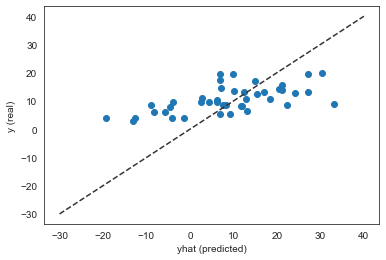

In [10]:
# this plot uses straight matplotlib commands, not seaborn:
plt.scatter(yhat, y)
plt.plot((-30, 40), (-30, 40), c=".2", ls="--");
plt.xlabel('yhat (predicted)')
plt.ylabel('y (real)')
plt.show()

From the scatterplot (with dashed identity line) you can see that I got the slope reasonably wrong. Let's compute the errors:

In [11]:
errors = y.T - yhat  # absolute errors for each data point
squared_errors = errors ** 2  # squared errors
sse = squared_errors.sum()  # sum of squared errors
sse

array(4307.09869943)

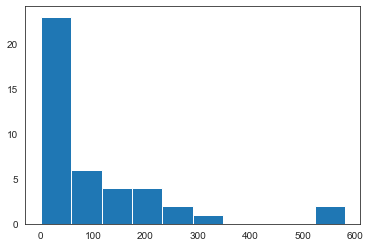

In [12]:
plt.hist(squared_errors.T);

# Statsmodels

Now we can use the Statsmodels package to estimate the best coefficients from the data. We will fit it using statsmodels' GLM function.

In [13]:
fit = sm.GLM(y, X).fit() # fit the design matrices we specified above using Patsy...
# let's look at the fit summary:
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             TotalSleep   No. Observations:                   42
Model:                            GLM   Df Residuals:                       40
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          14.065
Method:                          IRLS   Log-Likelihood:                -114.09
Date:                Mon, 07 Feb 2022   Deviance:                       562.62
Time:                        19:55:15   Pearson chi2:                     563.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.4046      0.599     19.049      0.0

The above table shows the results of fitting the simple linear regression. There's a bunch of information here. Let's go through some of it.

1. Note that we've fit a "Gaussian" model with the "identity" link function. That means we're doing ordinary linear regression, which as we said above is one case of the Generalised Linear Model. The identity link means that $f()$ (see above) is just the identity (i.e. it doesn't modify the linear predictor $\mathbf X \beta$ in any way).

1. We had 42 observations (i.e. all the complete cases in our sleep set). The residual degrees of freedom equals the number of observations minus 2, because we estimated 2 parameters from the data (intercept and slope). 

1. The table at the bottom shows us information about the individual parameters we estimated. The coefficient value of the intercept is 11.4, which is pretty close to my guess of 12. The slope of log bodyweight is -0.95, so my slope estimate was pretty rubbish.

1. The `z` score is the coefficient divided by its standard error, and the P value is testing whether that standardised coefficient score is different from zero. Both P values are highly significant here, so in this simple case we can infer that both parameters are contributing something useful to predicting the total amount of sleep. The final two columns give us the bounds of the confidence intervals on the coefficient estimates.

Let's compare the predictions of this model to those of my guesses.


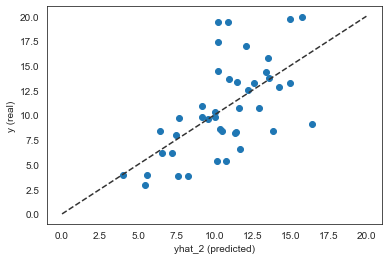

In [14]:
yhat_2 = fit.predict()

# note that internally, the fit.predict() function does something similar 
# to our inner product between X and beta, above.

plt.scatter(yhat_2, y)
plt.plot((-0, 20), (0, 20), c=".2", ls="--");
plt.xlabel('yhat_2 (predicted)')
plt.ylabel('y (real)')
plt.show()

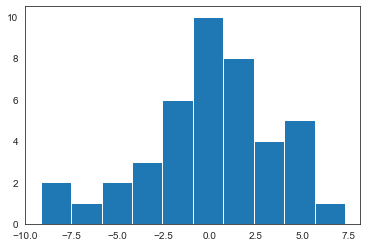

In [24]:
plt.hist(yhat_2.reshape(-1) - y.reshape(-1));

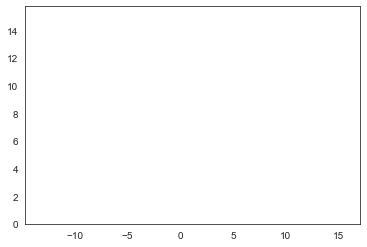

In [20]:
plt.hist(errors);

In [25]:
errors = y - yhat_2  # absolute errors for each data point
squared_errors = errors ** 2  # squared errors
sse2 = squared_errors.sum()  # sum of squared errors
sse2

array(52753.18037853)

You can see that the fitted values (SSE = 562.61) are far closer to the data than my guesses (SSE = 4302)... which is good.

### Statsmodels formula inputs

Note that we could also do the same thing by passing our Patsy formula to Statsmodels directly, using the statsmodels formula input:

In [26]:
sleep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 1 to 60
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Species      42 non-null     object 
 1   BodyWt       42 non-null     float64
 2   BrainWt      42 non-null     float64
 3   NonDreaming  42 non-null     float64
 4   Dreaming     42 non-null     float64
 5   TotalSleep   42 non-null     float64
 6   LifeSpan     42 non-null     float64
 7   Gestation    42 non-null     float64
 8   Predation    42 non-null     int64  
 9   Exposure     42 non-null     int64  
 10  Danger       42 non-null     int64  
 11  log_BodyWt   42 non-null     float64
 12  log_BrainWt  42 non-null     float64
dtypes: float64(9), int64(3), object(1)
memory usage: 4.6+ KB


In [27]:
fit_2 = smf.glm(formula='TotalSleep ~ log_BodyWt', data=sleep).fit()
print(fit_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             TotalSleep   No. Observations:                   42
Model:                            GLM   Df Residuals:                       40
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          14.065
Method:                          IRLS   Log-Likelihood:                -114.09
Date:                Mon, 07 Feb 2022   Deviance:                       562.62
Time:                        20:00:39   Pearson chi2:                     563.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.4046      0.599     19.049      0.0

In [28]:
fit_2.pearson_chi2

562.6176100349542

# Graphically exploring model fit

When fitting models, it's a good idea to look at graphical representations of model fit and the residuals (the distance between your predictions and your observations) to diagnose problems. Many plots of model fit are available in `Statsmodels`, at least for linear models (see [here](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/example_regression_plots.html)). 

We looked at one representation of the relationship between our model fits and the data above. Here are a few common plots.

In [29]:
# first we add to the sleep data frame, make a data frame of the stuff we want to plot:
plots_df = sleep[['TotalSleep', 'log_BodyWt']].copy()
plots_df['yhat'] = fit.predict()
plots_df['resids'] = plots_df['TotalSleep'] - plots_df['yhat']  
# note the fit object also contains various residuals.
plots_df.head()

TotalSleep  log_BodyWt       yhat    resids
1         8.3    0.000000  11.404567 -3.104567
4         3.9    7.842671   3.974367 -0.074367
5         9.8    2.356126   9.172358  0.627642
6        19.7   -3.772261  14.978433  4.721567
7         6.2    5.075174   6.596313 -0.396313

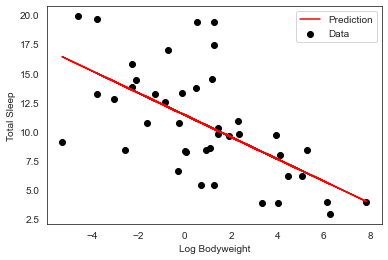

In [30]:
# plot predictions against real data:
plt.scatter(sleep['log_BodyWt'], sleep['TotalSleep'], c='k')
plt.plot(sleep['log_BodyWt'], fit.predict(), c='r')
plt.xlabel('Log Bodyweight')
plt.ylabel('Total Sleep')
plt.legend(['Prediction', 'Data'])
plt.show()

## Residual plots

Looking at the residuals as a function of our predictors can show some problems with the modelling assumptions. Recall that our model expects the observations to be independent and the errors normally distributed. We can check this graphically with a few plots.

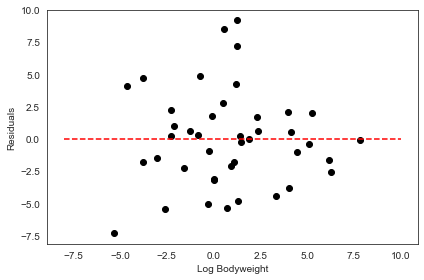

In [31]:
# plot residuals against bodyweight:
resids = fit.resid_pearson # sleep['TotalSleep'] - fit.predict()
plt.scatter(plots_df['log_BodyWt'], resids, c='k')
plt.plot((-8, 10), (0, 0), 'r--')
plt.xlabel('Log Bodyweight')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

Basically, we want the spread of the residuals around the zero line to look random. There shouldn't be anything systematic there -- if so, our model is missing non-random (i.e. predictable) relationships in the data.

For example (from [here](http://www.r-bloggers.com/model-validation-interpreting-residual-plots/)):

<img src="data/resid-plots.gif">

If your residuals plots look something like (b)–(f), think about expanding your model to capture the additional relationships in the data.

The distribution of residuals should also be approximately normal:

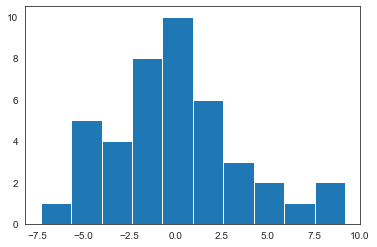

In [32]:
plt.hist(resids);

In this case, it looks a little right-skewed. That is, we might be violating the assumption of normality in residuals, but probably not drastically.

### Seaborn regression plots

Handily, Seaborn allows you to do some of these plots directly, without even doing the statsmodels fitting first. This is great for quickly exploring relationships in data, and happily the plots are also much prettier than the default Matplotlib figures. [See here for examples and code](http://stanford.edu/~mwaskom/software/seaborn/tutorial/quantitative_linear_models.html#visualizing-multiple-regression-with-lmplot).

In [33]:
sleep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 1 to 60
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Species      42 non-null     object 
 1   BodyWt       42 non-null     float64
 2   BrainWt      42 non-null     float64
 3   NonDreaming  42 non-null     float64
 4   Dreaming     42 non-null     float64
 5   TotalSleep   42 non-null     float64
 6   LifeSpan     42 non-null     float64
 7   Gestation    42 non-null     float64
 8   Predation    42 non-null     int64  
 9   Exposure     42 non-null     int64  
 10  Danger       42 non-null     int64  
 11  log_BodyWt   42 non-null     float64
 12  log_BrainWt  42 non-null     float64
dtypes: float64(9), int64(3), object(1)
memory usage: 4.6+ KB


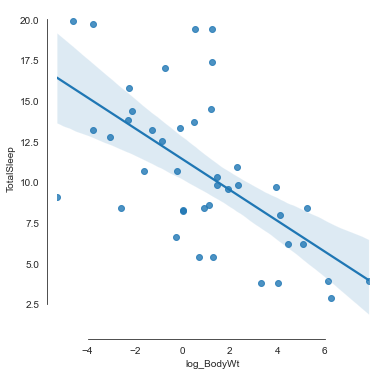

In [34]:
sns.lmplot('log_BodyWt', 'TotalSleep', data=sleep)
sns.despine(offset=10, trim=True);

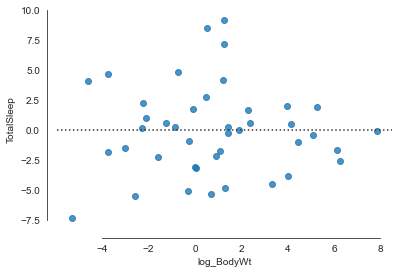

In [35]:
sns.residplot('log_BodyWt', 'TotalSleep', data=sleep)
sns.despine(offset=10, trim=True);

Internally these functions are fitting the same regression model as we wrote out above, using statsmodels, and wrapping it into pretty exploratory plots for us.

# Categorical variables and dummy coding

Some variables of interest will be categorical rather than metric / continuous. For example:

- gender is generally thought of as dichotomous (Male, Female)
- a person's religion might be one of a number of categories (Christian, Muslim, Buddhist, nonbeliever, ...)
- "Species" is an example from our dataset above

**How are categorical variables handled in the design matrix?**

Categorical variables are transformed into one or more design matrix columns with a specific meaning regarding the levels of the variable. The most common method, and the one we explore here, is called *Treatment* or *dummy coding*. You can see some examples of other coding schemes built into Patsy [here](http://patsy.readthedocs.org/en/latest/API-reference.html#categorical-coding-ref).

For the purposes of this demonstration, let's create a categorical variable "danger_cat" where we consider animals with either *high* or *low* danger of predation / exposure.

In [37]:
sleep['danger_cat'] = 'low'  # set as a string, "low" for all.
sleep.loc[sleep['Danger'] > 3, 'danger_cat'] = 'high'  # set Danger=4 or 5 to "high"
sleep['danger_cat']

1      low
4     high
5     high
6      low
7     high
8      low
9      low
10    high
11    high
14     low
15     low
16     low
17     low
21    high
22     low
24     low
26     low
27    high
28    high
31    high
32     low
33     low
36     low
37     low
38     low
39     low
41     low
42    high
43     low
44    high
45    high
47     low
48     low
49     low
50     low
51     low
53    high
56     low
57     low
58     low
59    high
60     low
Name: danger_cat, dtype: object

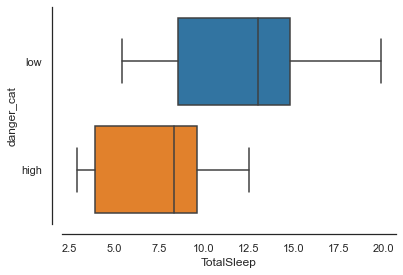

In [38]:
# how does total sleep appear to change according to our new categories?
sns.set_context('notebook')
g = sns.boxplot(x=sleep['TotalSleep'], y=sleep['danger_cat'])
sns.despine(ax=g, offset=10);

The low danger group seem to sleep for longer on average than the high danger group.

Now imagine we want to use a GLM to test this impression. **Is the total amount of sleep in the high danger group less than the low danger group?**

In [39]:
y, X = patsy.dmatrices('TotalSleep ~ C(danger_cat)', sleep)
X

DesignMatrix with shape (42, 2)
  Intercept  C(danger_cat)[T.low]
          1                     1
          1                     0
          1                     0
          1                     1
          1                     0
          1                     1
          1                     1
          1                     0
          1                     0
          1                     1
          1                     1
          1                     1
          1                     1
          1                     0
          1                     1
          1                     1
          1                     1
          1                     0
          1                     0
          1                     0
          1                     1
          1                     1
          1                     1
          1                     1
          1                     1
          1                     1
          1                     1
          1     

Now see that the design matrix column for `danger_cat` takes on two values: 0 (for high danger) and 1 (for low danger). What does this mean for the predictions? Let's think through what happens when we multiply these results by $\beta$.

When `danger_cat = 1`, 

$\hat y = \beta_1 * 1 + \beta_2 * 1$

when `danger_cat = 0`,

$\hat y = \beta_1 * 1 + \beta_2 * 0$

That is, the intercept coefficient $\beta_1$ represents the mean for the high danger group (`danger_cat = 0`), and the $\beta_2$ coefficient represents the *difference* between the means of the high group and the low group.

Let's see what those coefficients are:

In [40]:
fit = smf.glm(formula='TotalSleep ~ danger_cat', data=sleep).fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             TotalSleep   No. Observations:                   42
Model:                            GLM   Df Residuals:                       40
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          16.841
Method:                          IRLS   Log-Likelihood:                -117.87
Date:                Mon, 07 Feb 2022   Deviance:                       673.65
Time:                        20:06:12   Pearson chi2:                     674.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.2929      1.09

The intercept coefficient is 7.29 hours of sleep. You can see from the box plot above that this corresponds to the mean of the high danger group. The difference between the high and low group (the coefficient for danger_cat) is 5.02 hours. That is, the mean of the low danger group is 7.29 + 5.02 = 12.31 hours (again, check that this looks right according to the box plot). 

We can see from the z scores that given the variance in the samples (std err), the intercept is significantly different to zero (i.e. the high danger group sleep significantly more than zero hours) and that the difference between the high and low danger groups is also significant (i.e. the low danger group sleeps for significantly longer than the high danger group).

We've just tested two hypotheses. What do these tests remind you of?


## t-tests

Testing if the coefficient of the `danger_cat` variable is different to zero is (almost) the same as *an independent samples t-test*! It's not exactly the same because `glm` uses a z-test -- if we fitted the model with ordinary least squares [`smf.ols`] it would be exactly the same in this case.

To prove to ourselves that these are equivalent, let's do the appropriate tests:

In [41]:
high_array = sleep['TotalSleep'][sleep['danger_cat']=='high']
low_array = sleep['TotalSleep'][sleep['danger_cat']=='low']

In [42]:
# how does this compare to an independent groups z-test?
t, p = sm_stats.weightstats.ztest(high_array, low_array)
'Independent samples z-test: z = {t}, p = {p}'.format(t=np.round(t, decimals=3), p=p)

'Independent samples z-test: z = -3.741, p = 0.00018341854744738338'

In [43]:
fit.tvalues, fit.pvalues

(Intercept            6.649277
 danger_cat[T.low]    3.740823
 dtype: float64,
 Intercept            2.945355e-11
 danger_cat[T.low]    1.834185e-04
 dtype: float64)

In [44]:
'Model values: z = {t}, p = {p}'.format(
                        t=np.round(fit.tvalues[1], decimals=3), 
                        p=fit.pvalues[1])

'Model values: z = 3.741, p = 0.00018341854744738468'

So we can see that the values from the model are exactly the same as a z-test. What about t-test?

In [45]:
fit_ols = smf.ols(formula='TotalSleep ~ danger_cat', data=sleep).fit()
print(fit_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             TotalSleep   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     13.99
Date:                Mon, 07 Feb 2022   Prob (F-statistic):           0.000575
Time:                        20:09:55   Log-Likelihood:                -117.87
No. Observations:                  42   AIC:                             239.7
Df Residuals:                      40   BIC:                             243.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.2929      1.09

In [46]:
t, p, df = sm_stats.weightstats.ttest_ind(low_array, high_array)
'Independent samples t-test: t({df}) = {t}, p = {p}'.format(
    t=np.round(t, decimals=3), df=int(df), p=p)

'Independent samples t-test: t(40) = 3.741, p = 0.0005752964234035168'

In [47]:
'Model values: t = {t}, p = {p}'.format(
                        t=np.round(fit_ols.tvalues[1], decimals=3), 
                        p=fit_ols.pvalues[1])

'Model values: t = 3.741, p = 0.0005752964234035245'

They are identical to high precision!

# Categorical variable with more than one level

We learned above that "dummy coding" is when you transform a categorical variable into 0s and 1s in the design matrix. How does this work for categorical variables with more than two levels?

Let's try by treating the "Lifespan" variable (continuous, lifespan in years) as a *categorical* rather than *continuous* variable. I will create a new variable, grouping lifespan into three categories: short, medium, long.

To do this we will use Pandas' `qcut` function, which cuts a variable into groups based on quantiles. This creates a new Pandas Series whose type is `categorical`. While categories are going to be really useful in the future, right now they don't play nice with other packages (like statsmodels). For this reason, we will convert the category data type to a plain old object. See the docs for categories [here](https://pandas-docs.github.io/pandas-docs-travis/categorical.html).

In [51]:
sleep['life_cat'] = pd.qcut(sleep['LifeSpan'], [0, .33, .66, 1])
sleep['life_cat']

# category labels are a bit ugly, reflecting range of cuts:

1      (1.999, 6.765]
4     (20.428, 100.0]
5     (20.428, 100.0]
6     (6.765, 20.428]
7     (20.428, 100.0]
8     (20.428, 100.0]
9     (20.428, 100.0]
10    (6.765, 20.428]
11    (20.428, 100.0]
14     (1.999, 6.765]
15    (20.428, 100.0]
16     (1.999, 6.765]
17    (6.765, 20.428]
21    (6.765, 20.428]
22     (1.999, 6.765]
24    (20.428, 100.0]
26    (6.765, 20.428]
27    (6.765, 20.428]
28    (20.428, 100.0]
31     (1.999, 6.765]
32    (20.428, 100.0]
33    (20.428, 100.0]
36     (1.999, 6.765]
37     (1.999, 6.765]
38     (1.999, 6.765]
39     (1.999, 6.765]
41    (6.765, 20.428]
42    (6.765, 20.428]
43    (6.765, 20.428]
44    (20.428, 100.0]
45    (6.765, 20.428]
47     (1.999, 6.765]
48    (6.765, 20.428]
49    (20.428, 100.0]
50    (6.765, 20.428]
51     (1.999, 6.765]
53    (6.765, 20.428]
56     (1.999, 6.765]
57    (6.765, 20.428]
58     (1.999, 6.765]
59    (20.428, 100.0]
60     (1.999, 6.765]
Name: life_cat, dtype: category
Categories (3, interval[float64]): [(1.999, 

In [52]:
# change category labels, then convert to object:
sleep['life_cat'] = sleep['life_cat'].cat.rename_categories(['short', 'med', 'long']) # rename categories
sleep['life_cat'] = sleep['life_cat'].astype('object')  # make it an object, rather than a category
sleep['life_cat']

1     short
4      long
5      long
6       med
7      long
8      long
9      long
10      med
11     long
14    short
15     long
16    short
17      med
21      med
22    short
24     long
26      med
27      med
28     long
31    short
32     long
33     long
36    short
37    short
38    short
39    short
41      med
42      med
43      med
44     long
45      med
47    short
48      med
49     long
50      med
51    short
53      med
56    short
57      med
58    short
59     long
60    short
Name: life_cat, dtype: object

So now we have a new categorical variable, `life_cat`, with three levels. In this case it would be appropriate to analyse the categories as ordered (see [here](http://patsy.readthedocs.org/en/latest/API-reference.html#categorical-coding-ref) for how to do that in Patsy, and [here](http://www.ats.ucla.edu/stat/sas/webbooks/reg/chapter5/sasreg5.htm) for a discussion of different coding schemes). However, for simplicity here we're going to treat this as *unordered*, meaning that our model thinks the category order doesn't matter (e.g. with something like religion). 

What does Patsy do when we make a design matrix using a categorical predictor with more than 2 levels?

In [53]:
y, X = patsy.dmatrices('TotalSleep ~ C(life_cat)', sleep)
X

DesignMatrix with shape (42, 3)
  Intercept  C(life_cat)[T.med]  C(life_cat)[T.short]
          1                   0                     1
          1                   0                     0
          1                   0                     0
          1                   1                     0
          1                   0                     0
          1                   0                     0
          1                   0                     0
          1                   1                     0
          1                   0                     0
          1                   0                     1
          1                   0                     0
          1                   0                     1
          1                   1                     0
          1                   1                     0
          1                   0                     1
          1                   0                     0
          1                   1                   

You can see that we now have the intercept plus *two* additional columns, whose values can be zero or one. Take a look down the columns and compare them to the values of `sleep['life_cat']` above. 

Let's take for example the first 5 rows:

In [54]:
sleep['life_cat'].head()

1    short
4     long
5     long
6      med
7     long
Name: life_cat, dtype: object

In [55]:
X[0:5, :]  # first five rows, and second two cols of X

array([[1., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 1., 0.],
       [1., 0., 0.]])

Let's work through what this means for the Beta weights:

**For rows where 'life_cat' is 'long'**, the value of the two X columns is `[0, 0]`. Therefore, the prediction for TotalSleep in these rows is:

$\hat y = \beta_1 * 1 + \beta_2 * 0 + \beta_3 * 0$

$\hat y = \beta_1$

The first beta weight (the intercept) is therefore the mean of the 'long' group.

**For rows where 'life_cat' is 'short'**, the value of the two X columns is `[1, 0]`. Therefore, the prediction for TotalSleep in these rows is:

$\hat y = \beta_1 * 1 + \beta_2 * 1 + \beta_3 * 0$

$\hat y = \beta_1 + \beta_2$

The second beta weight is therefore the average *difference* between the 'long' group and the 'short' group.

Finally, **for rows where 'life_cat' is 'med'**, the value of the two X columns is `[0, 1]`. Therefore, the prediction for TotalSleep in these rows is:

$\hat y = \beta_1 * 1 + \beta_2 * 0 + \beta_3 * 1$

$\hat y = \beta_1 + \beta_3$

The third beta weight is therefore the average *difference* between the 'long' group and the 'med' group.

Let's see what these coefficients turn out to be, by fitting the model:

In [57]:
fit = smf.glm('TotalSleep ~ life_cat', sleep).fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             TotalSleep   No. Observations:                   42
Model:                            GLM   Df Residuals:                       39
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          20.078
Method:                          IRLS   Log-Likelihood:                -121.03
Date:                Mon, 07 Feb 2022   Deviance:                       783.06
Time:                        20:16:17   Pearson chi2:                     783.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.7071      1.19

If we add up these coefficients, we get some predictions for the mean amount of sleep in each category (intercept is just for the 'long' group):

In [58]:
long_mean = fit.params[0]
short_mean = fit.params[0] + fit.params[2]
med_mean = fit.params[0] + fit.params[1]

print('the predictions are: \
      \n long = {} \
      \n med = {} \
      \n short = {}'.format(np.round(long_mean, decimals=1), 
                          np.round(med_mean, decimals=1), 
                          np.round(short_mean, decimals=1)))

the predictions are:       
 long = 8.7       
 med = 10.3       
 short = 12.9


Let's check that against a boxplot (which plots medians, but will give us a good idea):

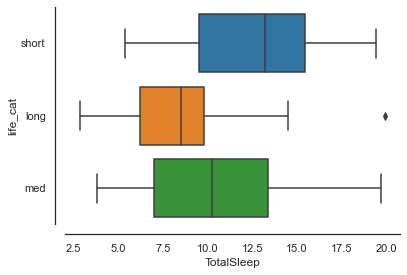

In [59]:
g = sns.boxplot(x=sleep['TotalSleep'], y=sleep['life_cat'])
sns.despine(ax=g, offset=10);

So that looks about right. As before, the z-tests of the coefficients compare groups. The 'short' lifespan group gets significantly more hours of sleep than the 'long' lifespan group (P = .013), but the difference between the 'med' and 'long' groups is not significant (P = .345).

## Reference level

In the scheme of setting up design matrices we use here, a categorical predictor will have $k - 1$ columns in the design matrix, where $k$ is the number of categories. For example, in our two category (Danger = low or high) example from before, there was $2 - 1 = 1$ column of the design matrix for this categorical predictor.

Note how the intercept takes on a meaning in these designs: the prediction for one of the categories. The category that corresponds to the intercept (or, when all the columns for this variable are zero) is called the *reference level* or *reference category*. The additional design matrix columns tell us how the non-reference categories differ from the reference level.

In Patsy, we can specify the reference level manually (e.g. if we wanted the intercept to be the mean of the 'short' group rather than the 'long' group). See the Patsy documentation [here](http://patsy.readthedocs.org/en/latest/categorical-coding.html) for how to do this.